### MNIST multi-class classification with XGBoost

In [1]:
from scipy.io import loadmat

import numpy as np

import xgboost as xgb
from xgboost import DMatrix

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import time

In [2]:
data = loadmat("MNIST.mat")
#print(data.keys())

train_fea = data['train_fea']
train_gnd = data['train_gnd']-1
test_fea = data['test_fea']
test_gnd = data['test_gnd']-1

### Train/Test Split

In [3]:
X_train, y_train = shuffle(train_fea, train_gnd, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.083333, random_state=42
)

X_test, y_test = shuffle(test_fea, test_gnd, random_state=42)

dtrain = DMatrix(X_train, label=y_train)
dval = DMatrix(X_val, label=y_val)
dtest = DMatrix(X_test, label=y_test)

# X_train shape: (55k, 784)
# y_train shape: (55k, 1)

# X_val shape: (5k, 784)
# y_val shape: (5k, 1)

# X_test shape: (10k, 784)
# y_test shape: (10k, 1)

### XGBoost without cross-validation

In [4]:
params = {
    "objective": "multi:softprob",
    "num_class": 10,
    "tree_method": "hist",
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "max_depth": 5,
    "eta": 0.1, # learning rate
    "eval_metric": "mlogloss",
    "seed": 42,
    "nthread": -1
}

evals = [(dtrain, 'train'), (dval, 'val')]

start = time.time()
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)
end = time.time()
train_time = end - start

start = time.time()
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)
end = time.time()
test_time = end - start

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Training time: {train_time:.2f}s")
print(f"Inference time: {test_time:.4f}s")
print(f"Accuracy: {acc:.3f}")
print(f"Best number of trees: {model.best_iteration}")
print(f"Classification report:\n{report}")

[0]	train-mlogloss:1.99753	val-mlogloss:1.99950
[100]	train-mlogloss:0.07064	val-mlogloss:0.13293
[200]	train-mlogloss:0.01779	val-mlogloss:0.08923
[300]	train-mlogloss:0.00568	val-mlogloss:0.07616
[400]	train-mlogloss:0.00246	val-mlogloss:0.07146
[500]	train-mlogloss:0.00136	val-mlogloss:0.06998
[530]	train-mlogloss:0.00119	val-mlogloss:0.06983
Training time: 365.76s
Inference time: 0.0940s
Accuracy: 0.981
Best number of trees: 480
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1135
           1       0.97      0.98      0.97      1032
           2       0.98      0.98      0.98      1010
           3       0.98      0.98      0.98       982
           4       0.99      0.97      0.98       892
           5       0.98      0.98      0.98       958
           6       0.98      0.97      0.98      1028
           7       0.98      0.98      0.98       974
           8       0.98      0.97      0.98      1009

Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

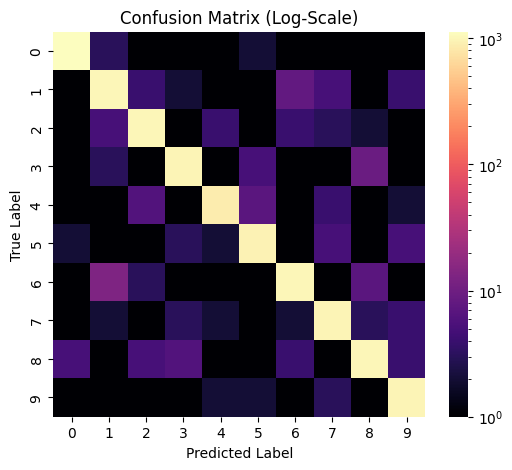

In [5]:
cm = confusion_matrix(y_test, y_pred)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma", norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")

### XGBoost with cross-validation

In [6]:
start = time.time()
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=3,
    stratified=True,
    early_stopping_rounds=50,
    verbose_eval=100,
    seed=42,
    as_pandas=True
)
end = time.time()

cv_time = end - start

best_n_estimators = len(cv_results)

print(f"Cross-validation training time: {cv_time:.2f}s")
print(f"Best number of boosting rounds from CV: {best_n_estimators}")

start = time.time()
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators,
    verbose_eval=100
)
end = time.time()
train_time = end - start

start = time.time()
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)
end = time.time()
test_time = end - start

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Training time (best model): {train_time:.2f}s")
print(f"Inference time: {test_time:.4f}s")
print(f"Accuracy: {acc:.3f}")
print(f"Classification report:\n{report}")

[0]	train-mlogloss:1.99303+0.00175	test-mlogloss:1.99995+0.00189
[100]	train-mlogloss:0.05952+0.00110	test-mlogloss:0.13589+0.00306
[200]	train-mlogloss:0.01248+0.00020	test-mlogloss:0.09429+0.00380
[300]	train-mlogloss:0.00394+0.00009	test-mlogloss:0.08413+0.00420
[400]	train-mlogloss:0.00185+0.00004	test-mlogloss:0.08131+0.00454
[500]	train-mlogloss:0.00115+0.00002	test-mlogloss:0.08084+0.00460
[596]	train-mlogloss:0.00084+0.00001	test-mlogloss:0.08089+0.00468
Cross-validation training time: 873.89s
Best number of boosting rounds from CV: 547
Training time (best model): 381.58s
Inference time: 0.0924s
Accuracy: 0.981
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1135
           1       0.97      0.98      0.98      1032
           2       0.98      0.98      0.98      1010
           3       0.98      0.98      0.98       982
           4       0.99      0.97      0.98       892
           5       0.98  

Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

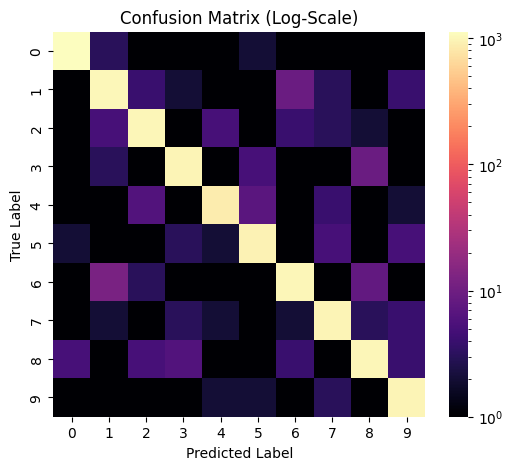

In [7]:
cm = confusion_matrix(y_test, y_pred)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma", norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")

### Using LeNet-5 Features:
 - Each image is represented as an 800-dimensional feature vector, obtained from a pretrained LeNet5 convolutional neural net (the output of the neurons at layer conv2)
- The images are the same as for the pixel-based images and appear in the same order

In [8]:
data_lenet = loadmat("MNIST-LeNet5.mat")
#print(data_lenet.keys())

train_fea = data_lenet['train_fea']
train_gnd = data_lenet['train_gnd']-1

test_fea = data_lenet['test_fea']
test_gnd = data_lenet['test_gnd']-1

# train_fea shape: (60k, 800)
# train_gnd shape: (60k, 1)
# test_fea shape: (10k, 800)
# test_gnd shape: (10k, 1)

In [9]:
X_train, y_train = shuffle(train_fea, train_gnd, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.083333, random_state=42
)

X_test, y_test = shuffle(test_fea, test_gnd, random_state=42)

dtrain = DMatrix(X_train, label=y_train)
dval = DMatrix(X_val, label=y_val)
dtest = DMatrix(X_test, label=y_test)

In [10]:
params = {
    "objective": "multi:softprob",
    "num_class": 10,
    "tree_method": "hist",
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "max_depth": 5,
    "eta": 0.1, # learning rate
    "eval_metric": "mlogloss",
    "seed": 42,
    "nthread": -1
}

evals = [(dtrain, 'train'), (dval, 'val')]

start = time.time()
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)
end = time.time()
train_time = end - start

start = time.time()
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)
end = time.time()
test_time = end - start

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Training time: {train_time:.2f}s")
print(f"Inference time: {test_time:.4f}s")
print(f"Accuracy: {acc:.3f}")
print(f"Best number of trees: {model.best_iteration}")
print(f"Classification report:\n{report}")

[0]	train-mlogloss:1.90243	val-mlogloss:1.90880
[100]	train-mlogloss:0.00834	val-mlogloss:0.04666
[200]	train-mlogloss:0.00106	val-mlogloss:0.03583
[300]	train-mlogloss:0.00045	val-mlogloss:0.03422
[400]	train-mlogloss:0.00030	val-mlogloss:0.03371
[433]	train-mlogloss:0.00028	val-mlogloss:0.03364
Training time: 198.33s
Inference time: 0.0596s
Accuracy: 0.990
Best number of trees: 383
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1135
           1       0.99      0.99      0.99      1032
           2       0.99      0.99      0.99      1010
           3       0.99      0.99      0.99       982
           4       0.99      0.99      0.99       892
           5       0.99      0.99      0.99       958
           6       0.98      0.99      0.99      1028
           7       0.99      0.99      0.99       974
           8       0.99      0.98      0.99      1009
           9       0.99      1.00      0.99      

Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

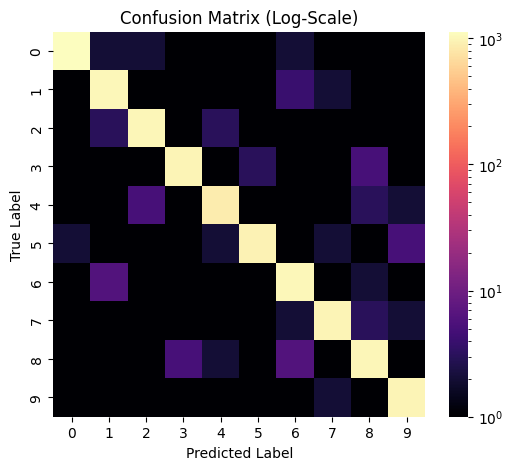

In [11]:
cm = confusion_matrix(y_test, y_pred)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma", norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")

In [12]:
start = time.time()
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=3,
    stratified=True,
    early_stopping_rounds=50,
    verbose_eval=100,
    seed=42,
    as_pandas=True
)
end = time.time()

cv_time = end - start

best_n_estimators = len(cv_results)

print(f"Cross-validation training time: {cv_time:.2f}s")
print(f"Best number of boosting rounds from CV: {best_n_estimators}")

start = time.time()
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators,
    verbose_eval=100
)
end = time.time()
train_time = end - start

start = time.time()
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)
end = time.time()
test_time = end - start

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Training time (best model): {train_time:.2f}s")
print(f"Inference time: {test_time:.4f}s")
print(f"Accuracy: {acc:.3f}")
print(f"Classification report:\n{report}")

[0]	train-mlogloss:1.90174+0.00063	test-mlogloss:1.90866+0.00080
[100]	train-mlogloss:0.00648+0.00019	test-mlogloss:0.04981+0.00181
[200]	train-mlogloss:0.00094+0.00002	test-mlogloss:0.04039+0.00183
[300]	train-mlogloss:0.00048+0.00001	test-mlogloss:0.03924+0.00179
[400]	train-mlogloss:0.00035+0.00000	test-mlogloss:0.03894+0.00175
[500]	train-mlogloss:0.00028+0.00000	test-mlogloss:0.03893+0.00177
[570]	train-mlogloss:0.00026+0.00000	test-mlogloss:0.03892+0.00172
Cross-validation training time: 500.98s
Best number of boosting rounds from CV: 521
Training time (best model): 225.27s
Inference time: 0.0758s
Accuracy: 0.990
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1135
           1       0.99      0.99      0.99      1032
           2       0.99      0.99      0.99      1010
           3       0.99      0.99      0.99       982
           4       0.99      0.99      0.99       892
           5       0.99  

Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

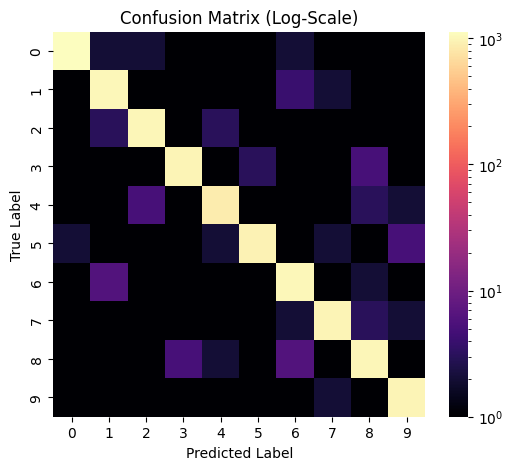

In [13]:
cm = confusion_matrix(y_test, y_pred)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma", norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")